## Libaries

In [45]:

#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
#Libaries for calculation and processing
from einops import rearrange, repeat
import math
from math import sqrt
from math import ceil
import numpy as np
from sklearn.preprocessing import StandardScaler
#libaries for data importng, formating and handling 
import pandas as pd
#For analysis and plotting
import matplotlib.pyplot as plt
import seaborn as sns
#others
import os
import time
import json
import pickle
import warnings
warnings.filterwarnings('ignore')

from data.Dataset import *
from model.Crossformer import *
from exp.ExpFish import *

## Hyperparameters

In [38]:
#DATASET 
ROOT_PATH = "Data/fishes/fish02/s1/"
DATA_PATH = "df_timeseries_red_clusters_s1.csv"
TRAIN_FLAG = "train"
VAL_FLAG = "val"
TEST_FLAG = "test"
SIZE=[100,100,100] #[seq_len, label_len, pred_len]
SCALE = True
SCALE_STATISTIC = True
DATA_SPLIT = [1, 0, 0.0]  # Train, Val, TEST
#DATALOADER 
BATCH_SIZE = 10
SHUFFLE_FLAG = False
NUM_WORKSES = 0
DROP_LAST = False

#MODEL 
DATA_DIM = 2 # number of clusers
IN_LEN   = SIZE[0]
OUT_LEN  = SIZE[2]
SEG_LEN  = 20
WIN_SIZE = 1
FACTOR   = 2
D_MODEL  = 256 
D_FF     = 512
N_HEADS  = 1
E_LAYERS = 1
DROPOUT  = 0.2
BASELINE = False

#Device
DEVICE   = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#OPTIMIZER
LR = 0.0001

#TRAINING 
NUM_EPOCHS = 5


# Experiment synthetic Sinus



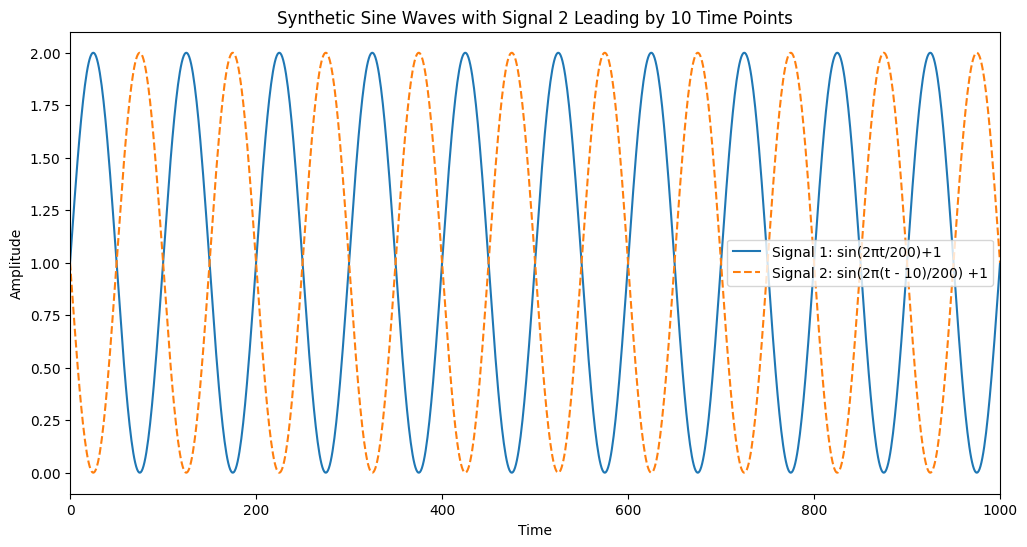

In [70]:
# Generate synthetic data with adjustments
t = np.linspace(0, 1000, 1000)  # Time variable from 0 to 1000
signal_1 = np.sin(2 * np.pi * t / 100) +1  # First sine wave
signal_2 = np.sin(2 * np.pi * (t - 50) / 100) +1 # Second sine wave, shifted to be ahead by 10 time points

# Plot the adjusted synthetic signals
plt.figure(figsize=(12, 6))
plt.plot(t, signal_1, label='Signal 1: sin(2πt/200)+1')
plt.plot(t, signal_2, label='Signal 2: sin(2π(t - 10)/200) +1', linestyle='--')
plt.legend()
plt.title('Synthetic Sine Waves with Signal 2 Leading by 10 Time Points')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.xlim(0, 1000)  # Limiting x-axis to show the leading effect more clearly
plt.show()



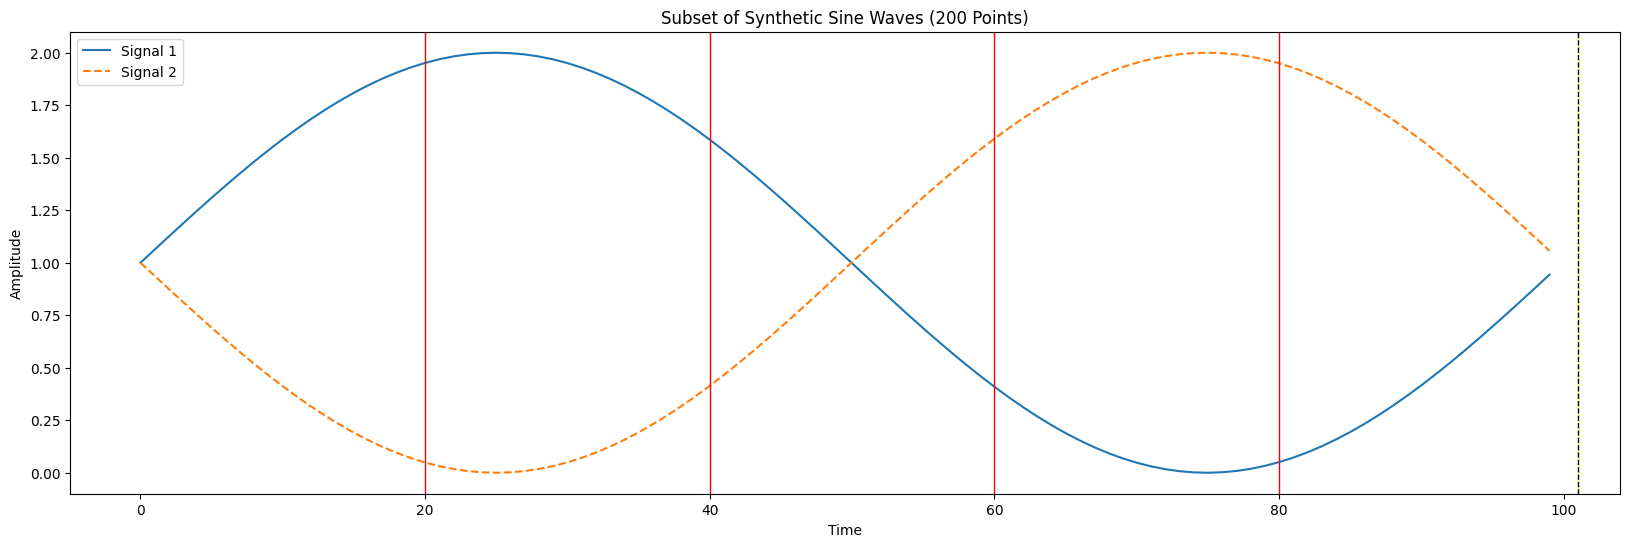

,Signal_1,Signal_2
0,1.000000,1.000000
1,1.062853,0.937147
2,1.125458,0.874542
3,1.187567,0.812433
4,1.248934,0.751066
...,...,...
195,0.702670,1.297330
196,0.763269,1.236731
197,0.824804,1.175196
198,0.887031,1.112969


In [71]:

# Creating a pandas DataFrame to store the synthetic data
df = pd.DataFrame({
    'Signal_1': signal_1,
    'Signal_2': signal_2
})

# Display the first few rows of the DataFrame
df.head()
len(df)


# Load 200 points for each of the signals from the DataFrame
df_subset = df.iloc[:100]

# Plot the subset of data for both signals
plt.figure(figsize=(20, 6))
plt.plot( df_subset['Signal_1'], label='Signal 1')
plt.plot( df_subset['Signal_2'], label='Signal 2', linestyle='--')
for x in range(SEG_LEN, SIZE[0], SEG_LEN):
    plt.axvline(x=x, color='red', linestyle='-', linewidth=1)
 
plt.axvline(x=101, color='yellow', linestyle='-', linewidth=1)   
plt.axvline(x=101, color='black', linestyle='--', linewidth=1)   

plt.legend()
plt.title('Subset of Synthetic Sine Waves (200 Points)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()
df.iloc[:200]


In [72]:
synth_data = Dataset_MTS_simplified(df_data=df,stride=1,size=SIZE,cols_target=[0,1])
data_loader_train_synth = DataLoader(
            synth_data,
            batch_size=BATCH_SIZE,
            shuffle=SHUFFLE_FLAG,
            num_workers=NUM_WORKSES,
            drop_last=DROP_LAST
            )



In [73]:
model_synt = Crossformer(
    data_dim=DATA_DIM,
    in_len=IN_LEN,
    out_len=OUT_LEN,
    seg_len=SEG_LEN,
    win_size=WIN_SIZE,
    factor=FACTOR,
    d_model=D_MODEL,
    d_ff=D_MODEL,
    n_heads=N_HEADS,
    e_layers=E_LAYERS,
    dropout=DROPOUT,
    baseline=False,
    device=DEVICE
    
).float()

criterion = nn.MSELoss()
optimizer = optim.Adam(model_synt.parameters(), lr=LR)

## Train

In [74]:
exp = Expfish(model=model_synt,
               data_loader_train=data_loader_train_synth,
               data_loader_test=None,
               data_loader_val=None,
               optimizer=optimizer,
               criterion=criterion,
               num_epochs=NUM_EPOCHS,
               device=DEVICE
               
               )

model_synt = exp.train()







	iters: 100, epoch: 1 | loss: 0.0962392
Epoch: 1 cost time: 6.81011700630188
Epoch: 1, Steps: 100 | Train Loss: 0.4424870 Vali Loss: 0.0000000
	iters: 100, epoch: 2 | loss: 0.0638706
Epoch: 2 cost time: 6.58603310585022
Epoch: 2, Steps: 100 | Train Loss: 0.0919192 Vali Loss: 0.0000000
	iters: 100, epoch: 3 | loss: 0.0471039
Epoch: 3 cost time: 6.41292667388916
Epoch: 3, Steps: 100 | Train Loss: 0.0762061 Vali Loss: 0.0000000
	iters: 100, epoch: 4 | loss: 0.0488015
Epoch: 4 cost time: 6.026677846908569
Epoch: 4, Steps: 100 | Train Loss: 0.0579682 Vali Loss: 0.0000000
	iters: 100, epoch: 5 | loss: 0.0380618
Epoch: 5 cost time: 6.315696716308594
Epoch: 5, Steps: 100 | Train Loss: 0.0577200 Vali Loss: 0.0000000


## Weights

In [76]:
tsa_layer = model_synt.encoder.encode_blocks[0].encode_layers[0]
tsa_layer_weights = tsa_layer.get_attn()
tsa_layer_weights[1]['att-A-B'].shape
len(tsa_layer_weights)
tsa_l = model_synt.decoder.decode_layers[0]
dec_attn=tsa_l.get_attn()
dec_attn[0]['dec_attnetion'][0, 0, :, :].cpu().numpy()
dec_attn[0]['dec_attnetion'][0, 0, :, :].cpu().numpy()
dec_attn[0]['dec_attnetion'].shape



torch.Size([20, 1, 5, 5])

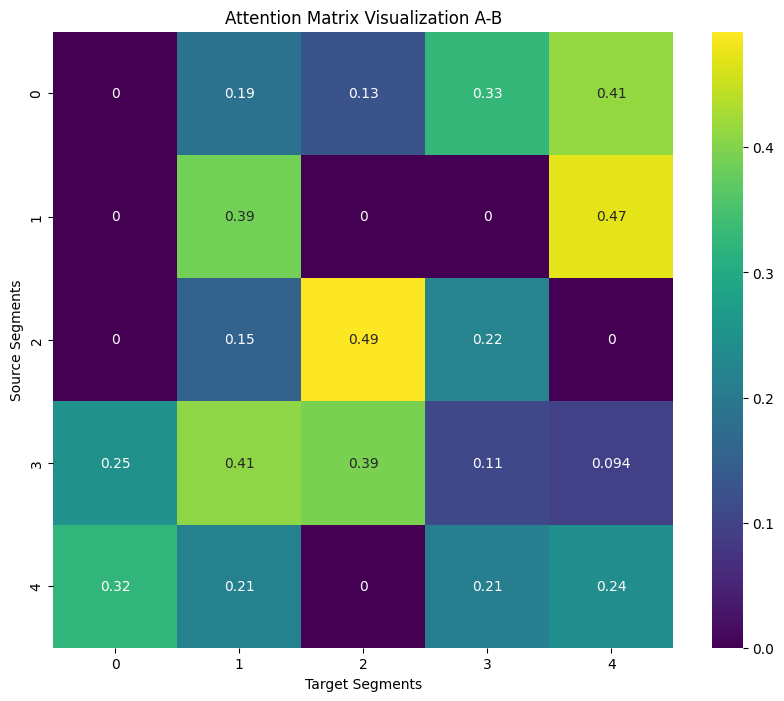

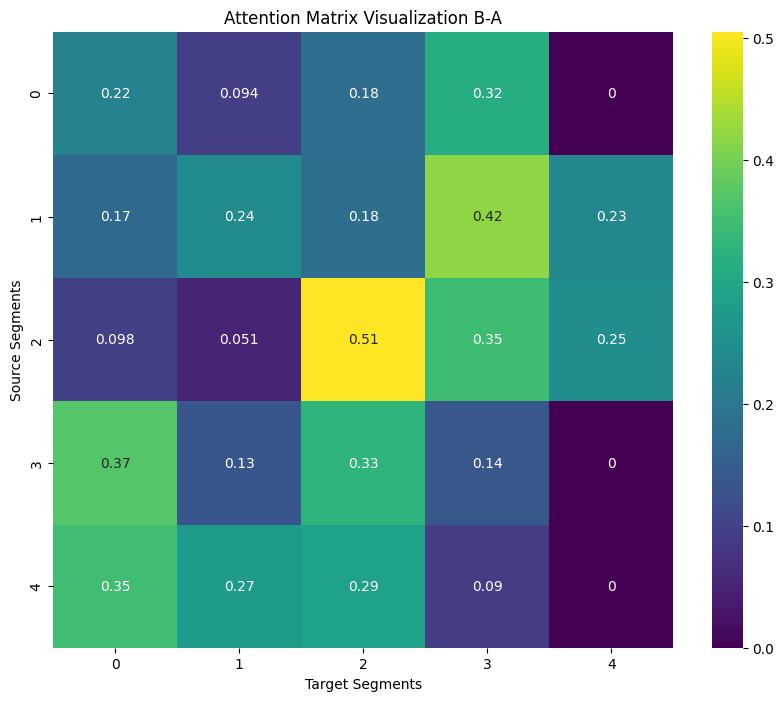

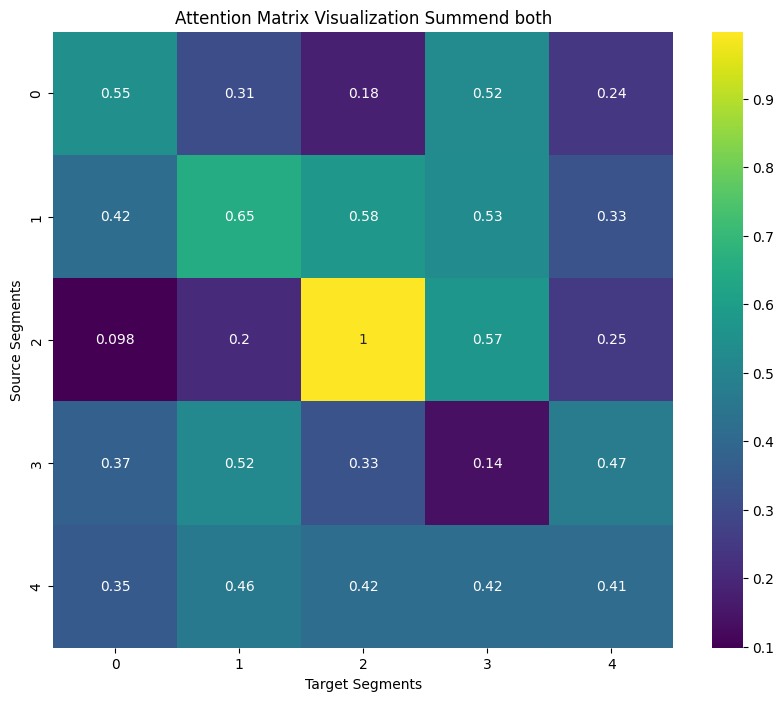

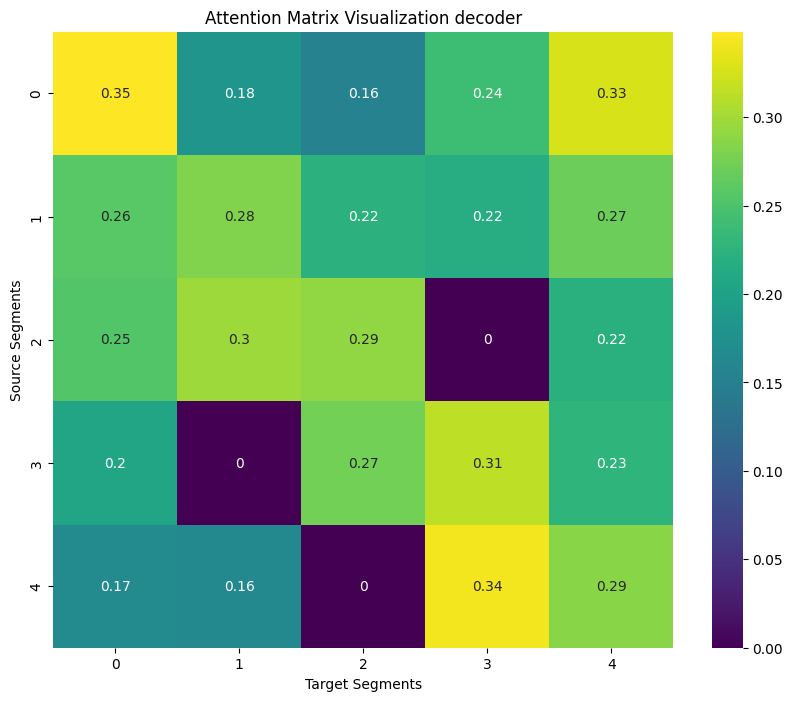

In [77]:
attention_matrix_rec = tsa_layer_weights[0]['att-A-B'][0, 0, :, :].cpu().numpy()
attention_matrix_send= tsa_layer_weights[0]['att-B-A'][0, 0, :, :].cpu().numpy()
att_plus_both = attention_matrix_rec + np.flipud(attention_matrix_send)
dec_attn = dec_attn[0]['dec_attnetion'][0, 0, :, :].cpu().numpy()
# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix_send, annot=True, cmap='viridis')
plt.title('Attention Matrix Visualization A-B')
plt.xlabel('Target Segments')
plt.ylabel('Source Segments')
plt.show()


# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(attention_matrix_rec, annot=True, cmap='viridis')
plt.title('Attention Matrix Visualization B-A')
plt.xlabel('Target Segments')
plt.ylabel('Source Segments')
plt.show()


# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(att_plus_both, annot=True, cmap='viridis')
plt.title('Attention Matrix Visualization Summend both')
plt.xlabel('Target Segments')
plt.ylabel('Source Segments')
plt.show()


# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(dec_attn, annot=True, cmap='viridis')
plt.title('Attention Matrix Visualization decoder')
plt.xlabel('Target Segments')
plt.ylabel('Source Segments')
plt.show()

In [78]:

model_synt.eval()
total_loss = 0
count = 0
preds =[]
with torch.no_grad():  
    for batch_idx, (inputs, targets) in enumerate(data_loader_train_synth):
        predictions = model_synt(inputs.float())  # Get model predictions
        
        predictions  = (predictions).numpy()
        
        preds.append(predictions)
# Example plot for the first signal in the batch


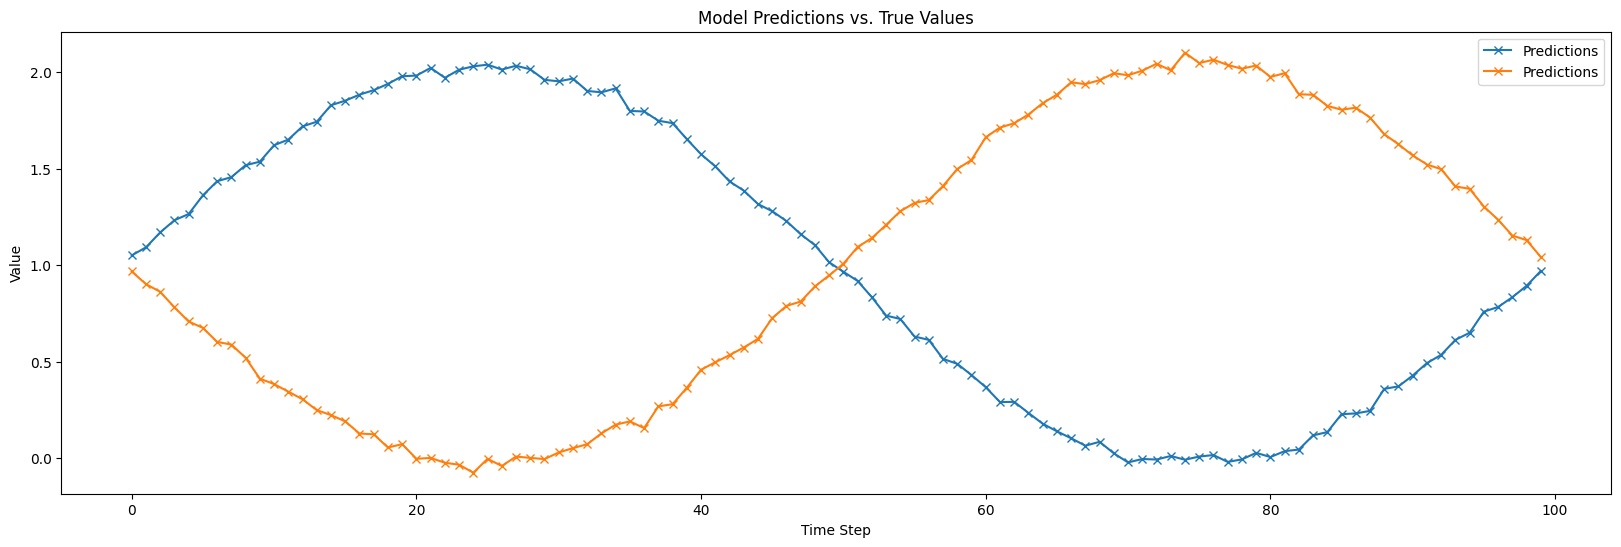

In [79]:
plt.figure(figsize=(20, 6))
plt.plot(preds[0][0], label='Predictions', marker='x') 
plt.legend()
plt.title('Model Predictions vs. True Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.show()


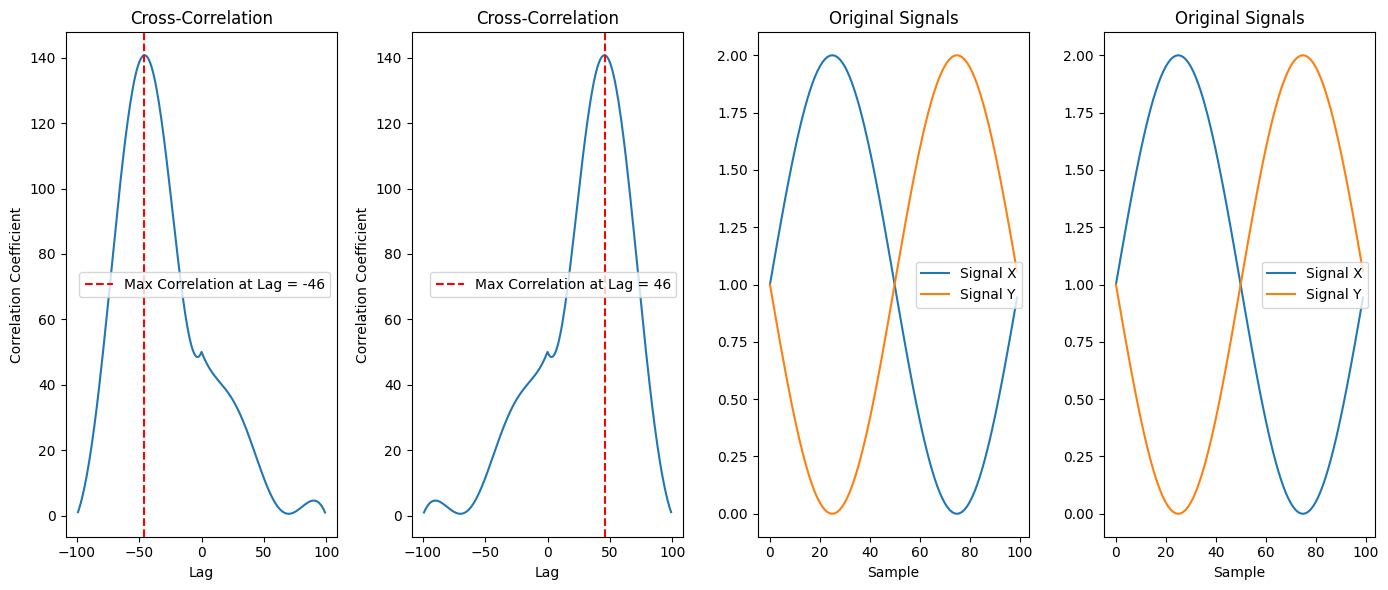

-46

In [80]:
import numpy as np
import matplotlib.pyplot as plt

x = signal_1[:100]
y = signal_2[:100]

cross_corr1 = np.correlate(x, y, mode='full')
cross_corr2 = np.correlate(y, x, mode='full')

# Find the lag with the maximum correlation
lags1 = np.arange(-len(x) + 1, len(y))
max_lag1 = lags1[np.argmax(cross_corr1)]

lags2 = np.arange(-len(x) + 1, len(y))
max_lag2 = lags2[np.argmax(cross_corr2)]

# Plotting
plt.figure(figsize=(14, 6))

# Cross-correlation plot
plt.subplot(1, 4, 1)
plt.plot(lags1, cross_corr1)
plt.title('Cross-Correlation')
plt.xlabel('Lag')
plt.ylabel('Correlation Coefficient')
plt.axvline(max_lag1, color='r', linestyle='--', label=f'Max Correlation at Lag = {max_lag1}')
plt.legend()


plt.subplot(1, 4, 2)
plt.plot(lags2, cross_corr2)
plt.title('Cross-Correlation')
plt.xlabel('Lag')
plt.ylabel('Correlation Coefficient')
plt.axvline(max_lag2, color='r', linestyle='--', label=f'Max Correlation at Lag = {max_lag2}')
plt.legend()

# Original signals for reference
plt.subplot(1, 4, 3)
plt.plot(x, label='Signal X')
plt.plot(y, label='Signal Y')
plt.title('Original Signals')
plt.xlabel('Sample')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(x, label='Signal X')
plt.plot(y, label='Signal Y')
plt.title('Original Signals')
plt.xlabel('Sample')
plt.legend()


plt.tight_layout()
plt.show()

max_lag1


## Experiment 